In [32]:
import numpy as np
import matplotlib.pyplot as plt

import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

## 1) Generating an artificial image of the sky (frequency domain)

In [33]:
#image of the sky filled with double precision complex floats ('complex64')
#pixels are set to low complex random values (image background/noise) 
#few pixels are set to larger complex random values in a specified ellipse area (image source/subject)

n = 10
noise = np.zeros((n, n), dtype='complex64')
noise.real = np.random.rand(n , n) / 100
noise.imag = np.random.rand(n , n) / 100

h, w = noise.shape
mask = circular_mask(h, w, radius=h/5)
sky_image = noise.copy()
sky_image[mask] = complex(np.random.rand() * 100, np.random.rand() * 100)
print(sky_image)

[[4.6084714e-03+9.7974697e-03j 6.5485048e-03+1.3066701e-03j
  9.2066359e-03+6.3321684e-03j 4.3678214e-03+4.2592320e-03j
  4.3743192e-03+6.4130574e-03j 4.8698713e-03+9.0742270e-03j
  4.2364509e-03+7.1217273e-03j 4.9504330e-03+9.7150577e-04j
  4.4534956e-03+7.6246588e-03j 5.1173274e-03+8.9141726e-03j]
 [3.1168738e-03+3.5816143e-04j 3.0896217e-03+7.9540247e-03j
  5.4305885e-03+5.1871291e-03j 2.4948928e-03+1.2360025e-03j
  3.6484669e-03+7.7051143e-03j 2.9453665e-03+7.4887197e-03j
  5.9105866e-03+1.3095250e-03j 2.6085631e-03+8.4767779e-03j
  1.9809683e-03+1.9095124e-03j 8.0105457e-03+6.4311130e-03j]
 [6.3556032e-03+1.5293519e-03j 8.8426536e-03+4.6882825e-03j
  7.5550372e-04+8.5531631e-03j 1.2943048e-03+3.8687452e-03j
  6.6330028e-03+7.0451098e-03j 6.6645099e-03+8.4460862e-03j
  6.9489572e-03+1.9868030e-03j 8.4211063e-03+9.3901986e-03j
  3.7788162e-03+7.7387993e-03j 1.9294961e-03+8.4210010e-03j]
 [2.2568628e-03+9.9647176e-03j 3.9231777e-03+1.8534559e-03j
  3.8329221e-03+8.6749988e-03j 5.3836

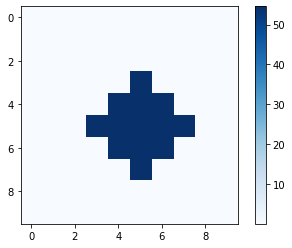

In [34]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar()

## 2) Applying a 2D FT (Fourier domain)

In [35]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 3.2074072e+02+6.33534363e+02j -2.5801489e+02-5.09900238e+02j
   1.2894626e+02+2.54962296e+02j -3.7641357e+01-7.44368439e+01j
   1.8786345e+01+3.72131042e+01j -2.4600138e+01-4.86444664e+01j
   1.8841902e+01+3.72098999e+01j -3.7655247e+01-7.44541702e+01j
   1.2901158e+02+2.54953720e+02j -2.5800293e+02-5.09868317e+02j]
 [-2.5795987e+02-5.09852814e+02j  1.9929944e+02+3.93889374e+02j
  -7.9759384e+01-1.57556778e+02j -2.9833128e-03+3.76306707e-03j
   9.3838377e+00+1.86313457e+01j -6.3746297e-03-1.35756768e-02j
   9.4583921e+00+1.85672703e+01j  7.2443075e-02+6.33961149e-03j
  -7.9695534e+01-1.57570496e+02j  1.9929062e+02+3.93871002e+02j]
 [ 1.2898007e+02+2.54936340e+02j -7.9704201e+01-1.57588837e+02j
  -1.5248190e+01-3.01134415e+01j  6.4485458e+01+1.27470329e+02j
  -4.9280941e+01-9.73484650e+01j  3.0400364e+01+6.02107925e+01j
  -4.9331539e+01-9.73615799e+01j  6.4474648e+01+1.27493393e+02j
  -1.5212850e+01-3.00739574e+01j -7.9702255e+01-1.57558594e+02j]
 [-3.7667324e+01-7.43882675e+01j  2.2

## 3) Source-finding classification

### Training labels

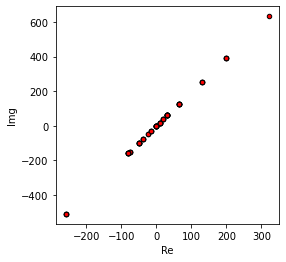

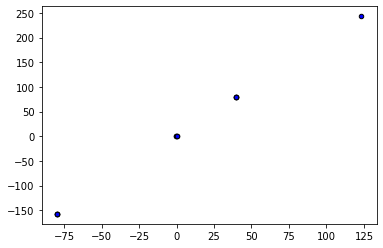

In [40]:
def labels(data, mask):
    
    Xvals, yvals = [], []
    
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j] == True:
                label = 1
            else:
                label = 0
        
            yvals.append(label)
            Xvals.append((data[i][j].real, data[i][j].imag))
        
    return pnp.array(Xvals, requires_grad=False), pnp.array(yvals, requires_grad=False)


def plot_data(x, y, fig=None, ax=None):
    
    reds = y == 0
    blues = y == 1
    plt.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.set_xlabel("Re")
    ax.set_ylabel("Img")
    plt.show()
    
    plt.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    plt.show()
    
    
Xdata, ydata = labels(visibilities, mask)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)


# Define output labels as quantum state vectors
def density_matrix(state):
    
    return state * pnp.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = pnp.array([label_0, label_1], requires_grad=False)

### Simple classifier with data reloading and fidelity loss

In [41]:
dev = qml.device("default.qubit", wires=1)
# Install any pennylane-plugin to run on some particular backend
# https://docs.pennylane.ai/projects/qiskit/en/latest/
# https://docs.pennylane.ai/en/stable/introduction/interfaces.html


@qml.qnode(dev)
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

### Utility functions for testing and creating batches

In [42]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return pnp.array(predicted), pnp.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

### Train a quantum classifier on the visibilities

In [ ]:
# Generate training and test data
X_data, y_data = labels(visibilities, mask)
# = np.array(X_data)
index = int(0.8*len(X_data))
X_train, y_train = X_data[:index], y_data[:index]
X_test, y_test = X_data[index:], y_data[index:]

X_train = pnp.hstack((X_train, pnp.zeros((X_train.shape[0], 1), requires_grad=False)))
X_test = pnp.hstack((X_test, pnp.zeros((X_test.shape[0], 1), requires_grad=False)))


# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 10
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = pnp.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.145050 | Train accuracy: 0.612500 | Test Accuracy: 0.700000


## Results

In [ ]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))


fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
plt.tight_layout()
plt.show()

## Utils

### Quantum

### Classical

In [2]:
#creates a circular mask over a 2D array
def circular_mask(h, w, center=None, radius=None):
    if center is None: #image center
        center = (int(w/2), int(h/2))
    if radius is None: #smallest distance between center and image bounderies
        radius = min(center[0], center[1], w-center[0], h-center[1])
        
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    
    return mask